# AQI for Different Indian Cities

Data Source: https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('city_day.csv')
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


## Data Cleaning

In [2]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])

# Extract Year and Month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Check missing values
print(df.isnull().sum())

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
Year              0
Month             0
dtype: int64


In [3]:
# Calculate percentage of missing values
missing_percent = df.isnull().mean() * 100

# Identify columns with more than 40% missing values
cols_to_drop = missing_percent[missing_percent > 30].index

# Drop those columns
df = df.drop(columns=cols_to_drop)

# Print dropped columns
print("Dropped columns:", list(cols_to_drop))

# Optional: verify remaining missing percentages
print("\nRemaining Missing Percentage:")
print(df.isnull().mean() * 100)

Dropped columns: ['PM10', 'NH3', 'Xylene']

Remaining Missing Percentage:
City           0.000000
Date           0.000000
PM2.5         15.570079
NO            12.129626
NO2           12.139785
NOx           14.171549
CO             6.972334
SO2           13.050692
O3            13.619586
Benzene       19.041008
Toluene       27.229014
AQI           15.851139
AQI_Bucket    15.851139
Year           0.000000
Month          0.000000
dtype: float64


In [10]:
pollutants = ['PM2.5','NO','NO2','NOx','CO',
              'SO2','O3','Benzene','Toluene']

# Sort to ensure the timeline is perfectly in order for each city
df = df.sort_values(['City','Date'])

# Apply interpolation first, then ffill and bfill
df[pollutants] = df.groupby('City')[pollutants].apply(
    lambda x: x.interpolate(method='linear').ffill().bfill()
).reset_index(level=0, drop=True)

# Clean the AQI column (Interpolate, then Forward Fill, then Backward Fill)
df['AQI'] = df.groupby('City')['AQI'].transform(
    lambda x: x.interpolate(method='linear').ffill().bfill()
)

# Clean the AQI_Bucket (ONLY Forward Fill and Backward Fill)
df['AQI_Bucket'] = df.groupby('City')['AQI_Bucket'].transform(
    lambda x: x.ffill().bfill()
)

print(df[pollutants].isnull().sum())
print(df['AQI'].isnull().sum())
print(df['AQI_Bucket'].isnull().sum())

PM2.5      0
NO         0
NO2        0
NOx        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
dtype: int64
0
0


In [11]:
# Fill the remaining blanks with the median for that specific pollutant
stubborn_cols = ['NOx', 'O3', 'Benzene', 'Toluene']

for col in stubborn_cols:
    df[col] = df[col].fillna(df[col].median())

# Final check
print(df[pollutants].isnull().sum())

PM2.5      0
NO         0
NO2        0
NOx        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
dtype: int64


## Analysis

In [12]:
# Summary statistics
print(df[['AQI','PM2.5','NO', 'NOx', 'NO2','SO2','O3', 'CO', 'Benzene', 'Toluene']].describe())

               AQI         PM2.5            NO           NOx           NO2  \
count  29531.00000  29531.000000  29531.000000  29531.000000  29531.000000   
mean     164.63755     71.042188     23.015583     32.764487     27.033618   
std      138.26182     74.679338     33.385821     31.462305     23.859672   
min       13.00000      0.040000      0.020000      0.000000      0.010000   
25%       78.00000     26.750000      5.930000     14.060000     10.650000   
50%      117.00000     48.050000     10.400000     23.790000     20.270000   
75%      206.00000     84.868441     23.230000     39.950000     35.240000   
max     2049.00000    949.990000    390.680000    467.630000    362.210000   

                SO2            O3            CO       Benzene       Toluene  
count  29531.000000  29531.000000  29531.000000  29531.000000  29531.000000  
mean      22.407083     33.288873      3.328664      3.292905      7.458921  
std       38.781125     21.310352     13.002122     15.767085  

### National AQI Trend (Yearly)



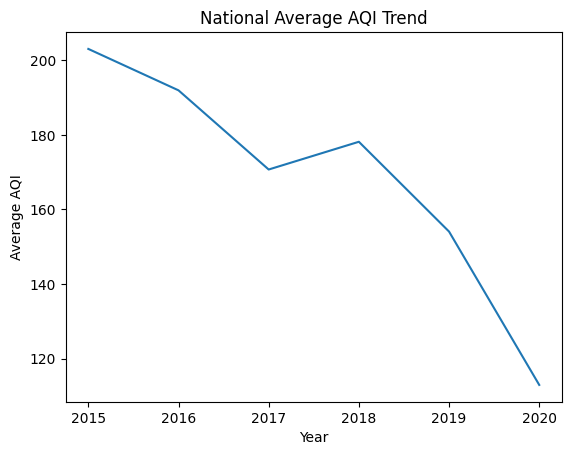

In [13]:
import matplotlib.pyplot as plt

yearly_avg = df.groupby('Year')['AQI'].mean()

plt.figure()
yearly_avg.plot()
plt.title("National Average AQI Trend")
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.show()

### Seasonal AQI Trend (Monthly)

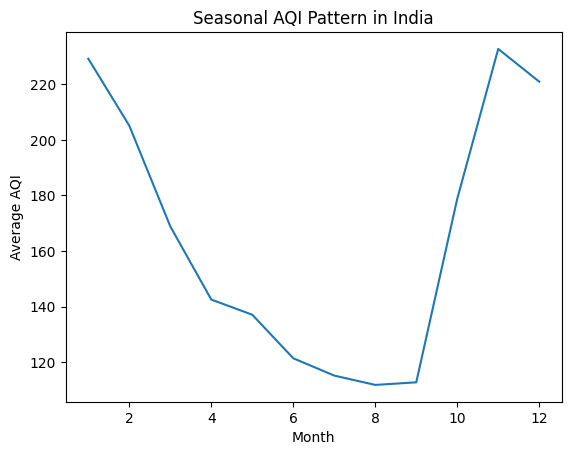

In [14]:
monthly_avg = df.groupby('Month')['AQI'].mean()

plt.figure()
monthly_avg.plot()
plt.title("Seasonal AQI Pattern in India")
plt.xlabel("Month")
plt.ylabel("Average AQI")
plt.show()

### National Trend over Years

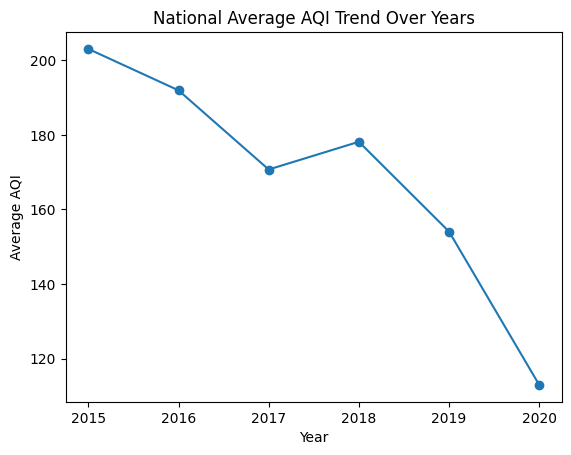

Year
2015    203.077738
2016    191.966732
2017    170.726842
2018    178.168181
2019    154.076656
2020    112.938274
Name: AQI, dtype: float64


In [15]:
import matplotlib.pyplot as plt

yearly_avg = df.groupby('Year')['AQI'].mean()

plt.figure()
yearly_avg.plot(marker='o')
plt.title("National Average AQI Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.show()

print(yearly_avg)

### Top 10 Most Polluted Cities (Hotspot Ranking)

In [18]:
city_avg = df.groupby('City')['AQI'].mean().sort_values(ascending=False)

print("Top 10 Most Polluted Cities:")
print(city_avg.head(10))

Top 10 Most Polluted Cities:
City
Ahmedabad       396.402937
Delhi           258.621453
Lucknow         232.348183
Patna           228.524758
Gurugram        227.107802
Talcher         172.471351
Brajrajnagar    151.828358
Jorapokhar      147.253208
Guwahati        139.539841
Kolkata         137.108108
Name: AQI, dtype: float64


### Severe Pollution Days (>200 AQI)

In [19]:
severe_days = df[df['AQI'] > 200]

severe_counts = severe_days.groupby('City')['AQI'].count().sort_values(ascending=False)

print("Cities with Most Severe Pollution Days:")
print(severe_counts.head(10))

Cities with Most Severe Pollution Days:
City
Ahmedabad       1633
Delhi           1301
Lucknow         1028
Gurugram         912
Patna            902
Talcher          291
Brajrajnagar     220
Chennai          213
Kolkata          198
Jorapokhar       193
Name: AQI, dtype: int64


### Correlation Matrix (Pollutant Drivers)

In [20]:
corr = df[['AQI','PM2.5','NO', 'NOx', 'NO2','SO2','O3', 'CO', 'Benzene', 'Toluene']].corr()

print(corr)

              AQI     PM2.5        NO       NOx       NO2       SO2        O3  \
AQI      1.000000  0.603766  0.170871  0.355500  0.507437  0.110321  0.204674   
PM2.5    0.603766  1.000000  0.134554  0.228980  0.250586  0.050155  0.120296   
NO       0.170871  0.134554  1.000000  0.628907  0.203032  0.587833 -0.079832   
NOx      0.355500  0.228980  0.628907  1.000000  0.524059  0.258605  0.057918   
NO2      0.507437  0.250586  0.203032  0.524059  1.000000  0.019882  0.310928   
SO2      0.110321  0.050155  0.587833  0.258605  0.019882  1.000000 -0.061942   
O3       0.204674  0.120296 -0.079832  0.057918  0.310928 -0.061942  1.000000   
CO       0.358473  0.084410  0.283038  0.121700  0.172560  0.170119 -0.006336   
Benzene  0.044599  0.015029 -0.017575  0.019209  0.035785 -0.029209  0.035479   
Toluene  0.275812  0.095868  0.017324  0.134784  0.287645  0.034221  0.148714   

               CO   Benzene   Toluene  
AQI      0.358473  0.044599  0.275812  
PM2.5    0.084410  0.015029 

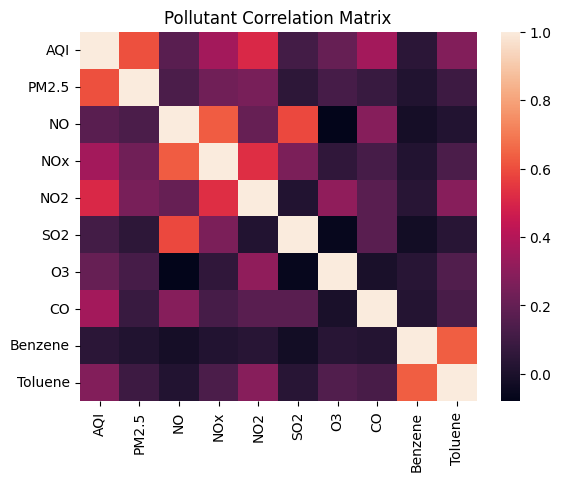

In [21]:
import seaborn as sns

plt.figure()
sns.heatmap(corr)
plt.title("Pollutant Correlation Matrix")
plt.show()

### Polution Hotspot cluster

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['PM2.5','NO2','SO2','O3','CO']

city_pollution = df.groupby('City')[features].mean()

scaler = StandardScaler()
scaled = scaler.fit_transform(city_pollution)

pca = PCA(n_components=1)
pollution_index = pca.fit_transform(scaled)

city_pollution['Pollution_Index'] = pollution_index

print(city_pollution.sort_values('Pollution_Index', ascending=False).head(10))

                    PM2.5        NO2        SO2         O3         CO  \
City                                                                    
Ahmedabad       78.162260  48.760473  51.647576  37.046583  32.926710   
Delhi          117.103559  50.796078  15.632700  50.299209   1.976053   
Lucknow        133.631986  33.213985  12.081697  37.416533   2.127914   
Patna          118.510183  36.430188  20.364952  36.752169   1.431060   
Bhopal          49.304706  30.752526  13.050657  59.827647   0.861073   
Jaipur          54.455794  32.265907  11.030036  46.383523   0.799713   
Gurugram       118.472159  25.070694   9.370146  33.785155   1.249720   
Kolkata         61.013385  39.876738   9.197721  30.996880   0.799251   
Jorapokhar     142.129897   9.256151  39.964333  31.044739   0.747066   
Visakhapatnam   44.002261  33.012011  12.113163  34.244511   0.737986   

               Pollution_Index  
City                            
Ahmedabad             3.784502  
Delhi                 2.

In [23]:
print("Explained Variance:", pca.explained_variance_ratio_)

Explained Variance: [0.42701883]


In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
city_pollution['Cluster'] = kmeans.fit_predict(scaled)

print(city_pollution.sort_values('Cluster'))

                         PM2.5        NO2         SO2         O3         CO  \
City                                                                          
Aizawl               16.848584   0.388496    7.378053   3.525664   0.283628   
Amaravati            36.585363  21.793601   14.367350  37.705426   0.605405   
Amritsar             54.246560  18.889779    8.635008  22.883387   0.555299   
Bengaluru            35.980553  27.971610    5.511672  33.412135   1.839609   
Brajrajnagar         65.340288  16.468060    9.681530  17.147340   1.739088   
Bhopal               49.304706  30.752526   13.050657  59.827647   0.861073   
Chandigarh           40.825263  11.737895   10.159375  20.047204   0.631349   
Chennai              55.355577  16.799077    7.812563  32.432952   1.068118   
Jaipur               54.455794  32.265907   11.030036  46.383523   0.799713   
Coimbatore           29.030997  28.838536    8.588174  28.800699   0.947850   
Ernakulam            24.862531   2.783611    3.17981

In [27]:
hotspots = city_pollution[city_pollution['Cluster'] > 0]

print("Pollution Hotspots:")
print(hotspots.index.tolist())

Pollution Hotspots:
['Ahmedabad', 'Delhi', 'Gurugram', 'Jorapokhar', 'Lucknow', 'Mumbai', 'Patna']


# Pollution due to Industrlisation

**Dataset Link:** https://www.data.gov.in/resource/comprehensive-environment-pollution-index-critically-polluted-industrial-areaclusters

In [29]:
df1 = pd.read_excel('Comphrehensive_Environment_Pollution_Index_For_Critically_Polluted_Industrial_Area_Clusters_1.xls')
df1.head()

,Industrial Cluster/Area,Air,Water,Land,CEPI
0,Ankaleshwar (Gujarat),72.00,72.75,75.75,88.50
1,Vapi (Gujarat),74.00,74.50,72.00,88.09
2,Bhiwadi (Rajasthan),71.00,69.00,59.50,82.91
3,Angul Talcher (Orissa),64.00,69.00,65.75,82.09
4,Vellore (North Arcot) (Tamil Nadu),69.25,65.25,62.50,81.79


In [30]:
top_cepi = df1.sort_values('CEPI', ascending=False)

print("Top 10 Industrial Pollution Hotspots:")
print(top_cepi.head(10))

Top 10 Industrial Pollution Hotspots:
              Industrial Cluster/Area   Air   Water   Land   CEPI
0               Ankaleshwar (Gujarat)  72.00  72.75  75.75  88.50
1                      Vapi (Gujarat)  74.00  74.50  72.00  88.09
2                 Bhiwadi (Rajasthan)  71.00  69.00  59.50  82.91
3              Angul Talcher (Orissa)  64.00  69.00  65.75  82.09
4  Vellore (North Arcot) (Tamil Nadu)  69.25  65.25  62.50  81.79
5           Singrauli (Uttar Pradesh)  70.50  64.00  59.50  81.73
6                   Ludhiana (Punjab)  68.00  66.00  64.75  81.66
7        Nazafgarh drain basin, Delhi  52.13  69.00  65.25  79.54
8                NOIDA (Uttar Pradesh  65.75  64.00  60.00  78.90
9                 Dhanbad (Jharkhand)  64.50  59.00  65.50  78.63


### Categorize Pollution Severity

In [31]:
def classify_cepi(x):
    if x >= 70:
        return "Critical"
    elif x >= 60:
        return "Severe"
    else:
        return "Moderate"

df1['Pollution_Category'] = df1['CEPI'].apply(classify_cepi)

print(df1['Pollution_Category'].value_counts())

Pollution_Category
Critical    28
Name: count, dtype: int64


In [32]:
df1['State'] = df1['Industrial Cluster/Area'].str.extract(r'\((.*?)\)')
print(df1[['Industrial Cluster/Area','State']].head())

              Industrial Cluster/Area        State
0               Ankaleshwar (Gujarat)      Gujarat
1                      Vapi (Gujarat)      Gujarat
2                 Bhiwadi (Rajasthan)    Rajasthan
3              Angul Talcher (Orissa)       Orissa
4  Vellore (North Arcot) (Tamil Nadu)  North Arcot


### State-Level Industrial Pollution Index

In [33]:
state_cepi = df1.groupby('State')['CEPI'].mean().reset_index()

state_cepi = state_cepi.sort_values('CEPI', ascending=False)

print(state_cepi.head(10))

            State       CEPI
8          Orissa  82.090000
7     North Arcot  81.790000
9          Punjab  81.660000
1         Gujarat  80.672500
10      Rajasthan  79.050000
3       Jharkhand  78.630000
12  Uttar Pradesh  77.522500
2         Haryana  77.070000
11     Tamil Nadu  76.885000
6     Maharashtra  75.953333


<Figure size 640x480 with 0 Axes>

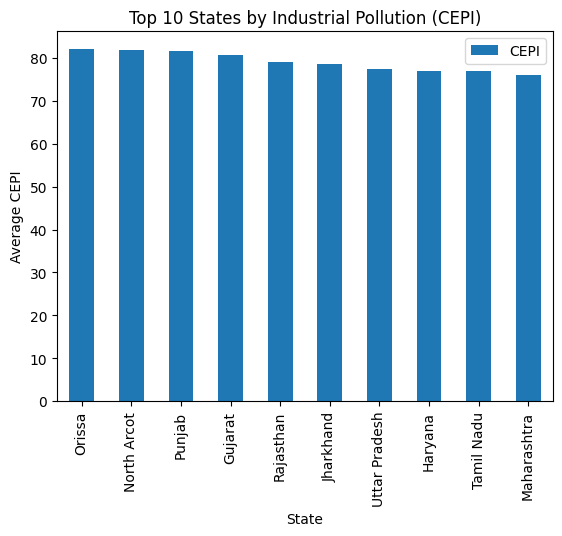

In [34]:
plt.figure()
state_cepi.sort_values('CEPI', ascending=False).head(10).plot(
    x='State', y='CEPI', kind='bar'
)
plt.title("Top 10 States by Industrial Pollution (CEPI)")
plt.ylabel("Average CEPI")
plt.show()

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
state_cepi['CEPI_Normalized'] = scaler.fit_transform(state_cepi[['CEPI']])

We're going to create a City, states, population mapped data

**Data Source:** https://www.kaggle.com/datasets/zed9941/top-500-indian-cities

In [43]:
cities_df = pd.read_csv('cities_r2.csv')
# Keep only required columns
cleaned_cities = cities_df[['state_code', 'state_name', 'name_of_city','population_total']].copy()

cleaned_cities.columns = ['State_Code', 'State', 'City','Population_Total']

# Standardize text formatting
cleaned_cities['City'] = cleaned_cities['City'].str.strip()
cleaned_cities['State'] = cleaned_cities['State'].str.strip()

# Save cleaned dataset
output_path = "./city_state_population_cleaned.csv"
cleaned_cities.to_csv(output_path, index=False)

# Display preview
print(cleaned_cities.head())

   State_Code           State       City  Population_Total
0           3          PUNJAB     Abohar            145238
1          27     MAHARASHTRA   Achalpur            112293
2          28  ANDHRA PRADESH   Adilabad            117388
3          20       JHARKHAND  Adityapur            173988
4          28  ANDHRA PRADESH      Adoni            166537


In [44]:
# Standardize text formatting
df['City'] = df['City'].str.strip()
cleaned_cities['City'] = cleaned_cities['City'].str.strip()

df = df.merge(cleaned_cities[['City','State']], on='City', how='left')

print("Unmatched Cities:", df['State'].isnull().sum())

Unmatched Cities: 11848


In [45]:
df = df.dropna(subset=['State'])

state_aqi = df.groupby('State')['AQI'].mean().reset_index()

print("\nState-Level AQI Preview:")
print(state_aqi.head())


State-Level AQI Preview:
            State         AQI
0  ANDHRA PRADESH  117.600889
1           ASSAM  139.539841
2           BIHAR  228.524758
3      CHANDIGARH   96.174342
4       KARNATAKA   94.086361


In [57]:
# Extract LAST parentheses content (true state)
df1['State'] = df1['Industrial Cluster/Area'].str.extract(r'\(([^()]*)\)\s*$')

df1['State'] = df1['State'].str.upper().str.strip()

In [58]:
state_aqi['State'] = state_aqi['State'].str.upper().str.strip()

state_aqi['State'] = state_aqi['State'].replace({
    'NCT OF DELHI': 'DELHI'
})

In [59]:
state_cepi = df1.groupby('State')['CEPI'].mean().reset_index()

merged = state_cepi.merge(state_aqi, on='State', how='inner')

print("Matched States:", len(merged))
print(merged)

Matched States: 8
            State     CEPI         AQI
0  ANDHRA PRADESH  70.8200  117.600889
1       KARNATAKA  73.6800   94.086361
2  MADHYA PRADESH  71.2600  130.484429
3          PUNJAB  81.6600  122.390254
4       RAJASTHAN  79.0500  133.364901
5      TAMIL NADU  78.5200  115.614196
6   UTTAR PRADESH  77.5225  232.348183
7     WEST BENGAL  73.4900  137.108108


In [60]:
print("States in AQI:", set(state_aqi['State']))
print("States in CEPI:", set(state_cepi['State']))

States in AQI: {'DELHI', 'TAMIL NADU', 'BIHAR', 'WEST BENGAL', 'CHANDIGARH', 'RAJASTHAN', 'MADHYA PRADESH', 'ANDHRA PRADESH', 'KARNATAKA', 'MEGHALAYA', 'UTTAR PRADESH', 'PUNJAB', 'MIZORAM', 'ASSAM', 'KERALA'}
States in CEPI: {'HARYANA', 'TAMIL NADU', 'GUJARAT', 'ORISSA', 'WEST BENGAL', 'RAJASTHAN', 'MADHYA PRADESH', 'ANDHRA PRADESH', 'KARNATAKA', 'UTTAR PRADESH', 'PUNJAB', 'MAHARASHTRA', 'JHARKHAND'}


In [61]:
# Pearson correlation
correlation_matrix = merged[['CEPI','AQI']].corr(method='pearson')

print("Pearson Correlation Matrix:")
print(correlation_matrix)

pearson_value = correlation_matrix.loc['CEPI','AQI']
print("\nPearson Correlation Coefficient:", pearson_value)

Pearson Correlation Matrix:
          CEPI       AQI
CEPI  1.000000  0.195206
AQI   0.195206  1.000000

Pearson Correlation Coefficient: 0.19520619646894954


# Plastic Waste by States

**Data Link: ** https://www.data.gov.in/resource/stateut-wise-details-plastic-waste-generation-state-pollution-control-boards-spcbs

In [62]:
plastic_df = pd.read_csv('State_UT plastic waste.csv')
plastic_df.head()

,Sl. No.,State/UT,2018-19,2019-20,2020-21,2021-22,2022-23
0,1,Andhra Pradesh,66314.00,46222.0,39626.45,36620.10,64339.41
1,2,Andaman and Nicobar Island,1850.00,387.0,492.34,688.03,744.00
2,3,Arunachal Pradesh,3787.37,2721.0,3755.90,1693.65,1113.20
3,4,Assam,32277.87,24971.0,58765.00,38388.50,30450.00
4,5,Bihar,68903.33,41365.0,74263.69,53232.34,63361.56


In [67]:
# Keep only required columns
plastic_df = plastic_df[['State/UT','2018-19','2019-20','2020-21','2021-22','2022-23']]

plastic_df = plastic_df.rename(columns={'State/UT':'State'})

# Standardize state names
plastic_df['State'] = plastic_df['State'].str.upper().str.strip()
plastic_df = plastic_df[plastic_df['State'] != 'TOTAL']

# Remove LADAKH
plastic_df = plastic_df[plastic_df['State'] != 'LADAKH']

# Convert to numeric
year_columns = ['2018-19','2019-20','2020-21','2021-22','2022-23']
plastic_df[year_columns] = plastic_df[year_columns].apply(pd.to_numeric, errors='coerce')

print(plastic_df.isnull().sum())

State      0
2018-19    0
2019-20    0
2020-21    0
2021-22    1
2022-23    1
dtype: int64


In [69]:
year_columns = ['2018-19','2019-20','2020-21','2021-22','2022-23']

plastic_df[year_columns] = plastic_df[year_columns].interpolate(axis=1)
print(plastic_df.isnull().sum())

State      0
2018-19    0
2019-20    0
2020-21    0
2021-22    0
2022-23    0
dtype: int64


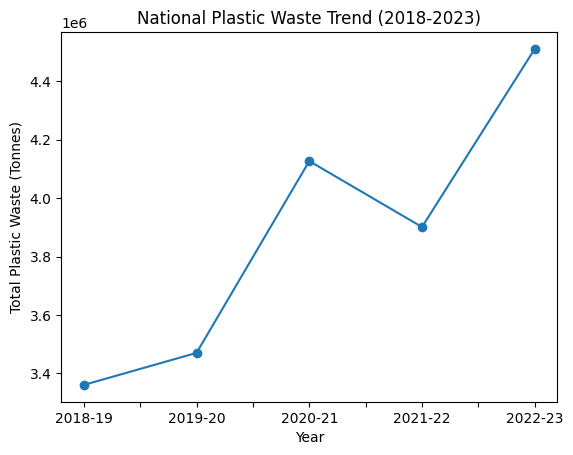

National Plastic Waste by Year:
2018-19    3360043.46
2019-20    3469781.73
2020-21    4126999.44
2021-22    3901094.31
2022-23    4511278.33
dtype: float64


In [70]:
national_trend = plastic_df[year_columns].sum()

plt.figure()
national_trend.plot(marker='o')
plt.title("National Plastic Waste Trend (2018-2023)")
plt.xlabel("Year")
plt.ylabel("Total Plastic Waste (Tonnes)")
plt.show()

print("National Plastic Waste by Year:")
print(national_trend)

### STATE AVERAGE PLASTIC WASTE

In [71]:
plastic_df['Average_Plastic'] = plastic_df[year_columns].mean(axis=1)

top_states = plastic_df.sort_values('Average_Plastic', ascending=False)

print("\nTop 10 Plastic Waste Generating States (Average):")
print(top_states[['State','Average_Plastic']].head(10))


Top 10 Plastic Waste Generating States (Average):
             State  Average_Plastic
30      TAMIL NADU       488523.536
31       TELANGANA       382560.930
20     MAHARASHTRA       370670.800
16       KARNATAKA       365209.520
10         GUJARAT       337652.226
8            DELHI       316255.644
34   UTTAR PRADESH       308679.960
35     WEST BENGAL       288404.630
11         HARYANA       142182.094
19  MADHYA PRADESH       129491.774


In [72]:
plastic_df['Growth_%'] = (
    (plastic_df['2022-23'] - plastic_df['2018-19'])
    / plastic_df['2018-19']
) * 100

growth_rank = plastic_df.sort_values('Growth_%', ascending=False)

print("\nTop 10 States by Plastic Waste Growth Rate (%):")
print(growth_rank[['State','Growth_%']].head(10))


Top 10 States by Plastic Waste Growth Rate (%):
               State      Growth_%
23           MIZORAM  36227.648385
29            SIKKIM   1395.406360
32           TRIPURA   1225.534351
18       LAKSHADWEEP    817.567568
7              DAMAN    630.468245
12  HIMACHAL PRADESH    283.811819
27       PONDICHERRY    268.635124
6       CHHATTISGARH    252.833333
31         TELANGANA    188.785625
19    MADHYA PRADESH    152.481805


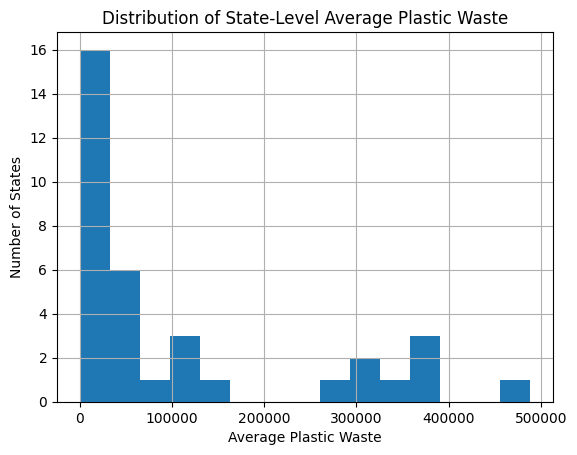


Number of States Analysed: 35


In [73]:
plt.figure()
plastic_df['Average_Plastic'].hist(bins=15)
plt.title("Distribution of State-Level Average Plastic Waste")
plt.xlabel("Average Plastic Waste")
plt.ylabel("Number of States")
plt.show()

print("\nNumber of States Analysed:", len(plastic_df))


**Merge the `plastic_df` (using `Average_Plastic`), `state_aqi`, and `state_cepi` DataFrames into a single DataFrame based on the 'State' column. Ensure all 'State' columns are standardized (uppercase and stripped) before merging to maximize matches.**


In [74]:
plastic_data_for_merge = plastic_df[['State', 'Average_Plastic']]

print("Plastic Data for Merge Preview:")
print(plastic_data_for_merge.head())

Plastic Data for Merge Preview:
                        State  Average_Plastic
0              ANDHRA PRADESH        50624.392
1  ANDAMAN AND NICOBAR ISLAND          832.274
2           ARUNACHAL PRADESH         2614.224
3                       ASSAM        36970.474
4                       BIHAR        60225.184


In [75]:
merged_aqi_cepi = state_cepi.merge(state_aqi, on='State', how='inner')

print("Merged AQI and CEPI Data Preview:")
print(merged_aqi_cepi.head())

Merged AQI and CEPI Data Preview:
            State   CEPI         AQI
0  ANDHRA PRADESH  70.82  117.600889
1       KARNATAKA  73.68   94.086361
2  MADHYA PRADESH  71.26  130.484429
3          PUNJAB  81.66  122.390254
4       RAJASTHAN  79.05  133.364901


In [76]:
final_merged_df = merged_aqi_cepi.merge(plastic_data_for_merge, on='State', how='inner')

print("Final Merged Data Preview (AQI, CEPI, Plastic Waste):")
print(final_merged_df.head())

Final Merged Data Preview (AQI, CEPI, Plastic Waste):
            State   CEPI         AQI  Average_Plastic
0  ANDHRA PRADESH  70.82  117.600889        50624.392
1       KARNATAKA  73.68   94.086361       365209.520
2  MADHYA PRADESH  71.26  130.484429       129491.774
3          PUNJAB  81.66  122.390254       108868.058
4       RAJASTHAN  79.05  133.364901        75656.492


### Check for Correlation
Calculate the Pearson correlation matrix between 'AQI', 'CEPI', and 'Average_Plastic' from the merged DataFrame.


In [77]:
overall_correlation_matrix = final_merged_df[['AQI', 'CEPI', 'Average_Plastic']].corr(method='pearson')

print("Overall Pearson Correlation Matrix:")
print(overall_correlation_matrix)

Overall Pearson Correlation Matrix:
                      AQI      CEPI  Average_Plastic
AQI              1.000000  0.195206         0.056694
CEPI             0.195206  1.000000         0.125857
Average_Plastic  0.056694  0.125857         1.000000


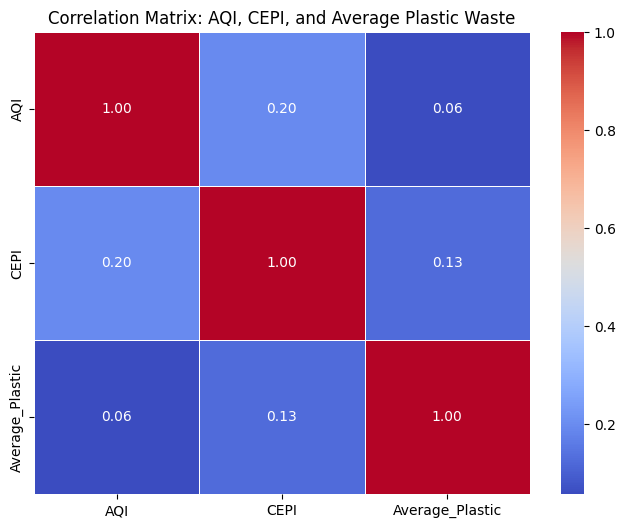

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(overall_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix: AQI, CEPI, and Average Plastic Waste")
plt.show()


### Summary of Correlations

The correlation matrix shows the following relationships between AQI, CEPI, and Average Plastic Waste:

*   **AQI and CEPI**: There is a weak positive correlation (approximately 0.195) between AQI (Air Quality Index) and CEPI (Comprehensive Environmental Pollution Index for industrial areas). This suggests that while industrial pollution might contribute to overall air quality, it is not a strong sole predictor of AQI at the state level in this dataset.

*   **AQI and Average Plastic Waste**: There is a very weak positive correlation (approximately 0.057) between AQI and Average Plastic Waste. This indicates that, based on this dataset and state-level averages, plastic waste generation does not have a significant linear relationship with air quality as measured by AQI.

*   **CEPI and Average Plastic Waste**: There is a weak positive correlation (approximately 0.126) between CEPI and Average Plastic Waste. This suggests a slight tendency for states with higher industrial pollution to also generate more plastic waste, but the relationship is not strong.

#The Digital Outarchy

Dataset link: https://www.kaggle.com/datasets/deffro/the-climate-change-twitter-dataset?select=The+Climate+Change+Twitter+Dataset.csv

In [88]:
!pip install pytrends

from pytrends.request import TrendReq
import pandas as pd

In [89]:
pytrends = TrendReq(hl='en-IN', tz=330)

In [91]:
keywords = [
    "air pollution",
    "climate change",
    "plastic waste",
    "air quality index",
    "global warming"
]

In [92]:
pytrends.build_payload(
    keywords,
    timeframe='2015-01-01 2023-12-31',
    geo='IN'
)

trends = pytrends.interest_over_time()

print(trends.head())

            air pollution  climate change  plastic waste  air quality index  \
date                                                                          
2015-01-01              8               3              1                  0   
2015-02-01              8               3              1                  0   
2015-03-01              5               2              1                  0   
2015-04-01              5               3              1                  1   
2015-05-01              5               3              1                  0   

            global warming  isPartial  
date                                   
2015-01-01              11      False  
2015-02-01               9      False  
2015-03-01               6      False  
2015-04-01               6      False  
2015-05-01               7      False  


In [93]:
trends = trends.drop(columns=['isPartial'])

In [94]:
trends['Year'] = trends.index.year

yearly_trends = trends.groupby('Year').mean()

print(yearly_trends)

      air pollution  climate change  plastic waste  air quality index  \
Year                                                                    
2015       6.666667        3.250000       1.000000           0.166667   
2016       7.416667        3.166667       1.000000           0.250000   
2017       7.166667        2.833333       1.000000           0.583333   
2018       6.833333        2.250000       1.000000           0.833333   
2019       7.916667        3.000000       1.250000           2.500000   
2020       6.166667        3.166667       1.000000           2.166667   
2021       6.666667        3.916667       1.166667           1.416667   
2022       9.500000       13.583333       1.083333           1.416667   
2023       7.500000        8.500000       1.083333           1.750000   

      global warming  
Year                  
2015        9.166667  
2016        9.916667  
2017        8.583333  
2018        6.583333  
2019        6.333333  
2020        5.000000  
2021        

<Figure size 640x480 with 0 Axes>

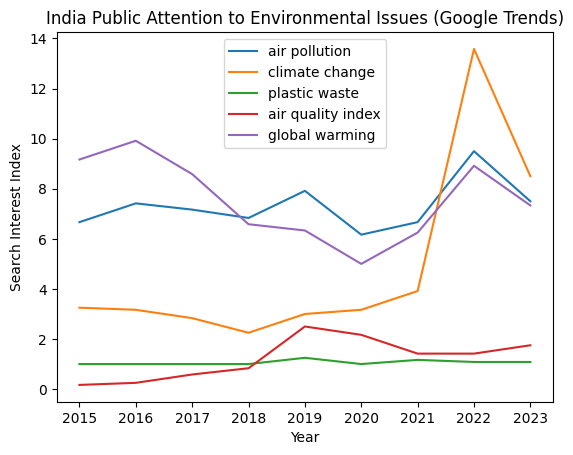

In [95]:
import matplotlib.pyplot as plt

plt.figure()
yearly_trends.plot()
plt.title("India Public Attention to Environmental Issues (Google Trends)")
plt.xlabel("Year")
plt.ylabel("Search Interest Index")
plt.show()

In [96]:
pytrends.build_payload(["air pollution"], timeframe='2015-01-01 2023-12-31', geo='IN')

regional_interest = pytrends.interest_by_region(resolution='REGION')

print(regional_interest.head())

                             air pollution
geoName                                   
Andaman and Nicobar Islands             32
Andhra Pradesh                          31
Arunachal Pradesh                       57
Assam                                   39
Bihar                                   18


Fetching data from Google... This might take a few seconds!


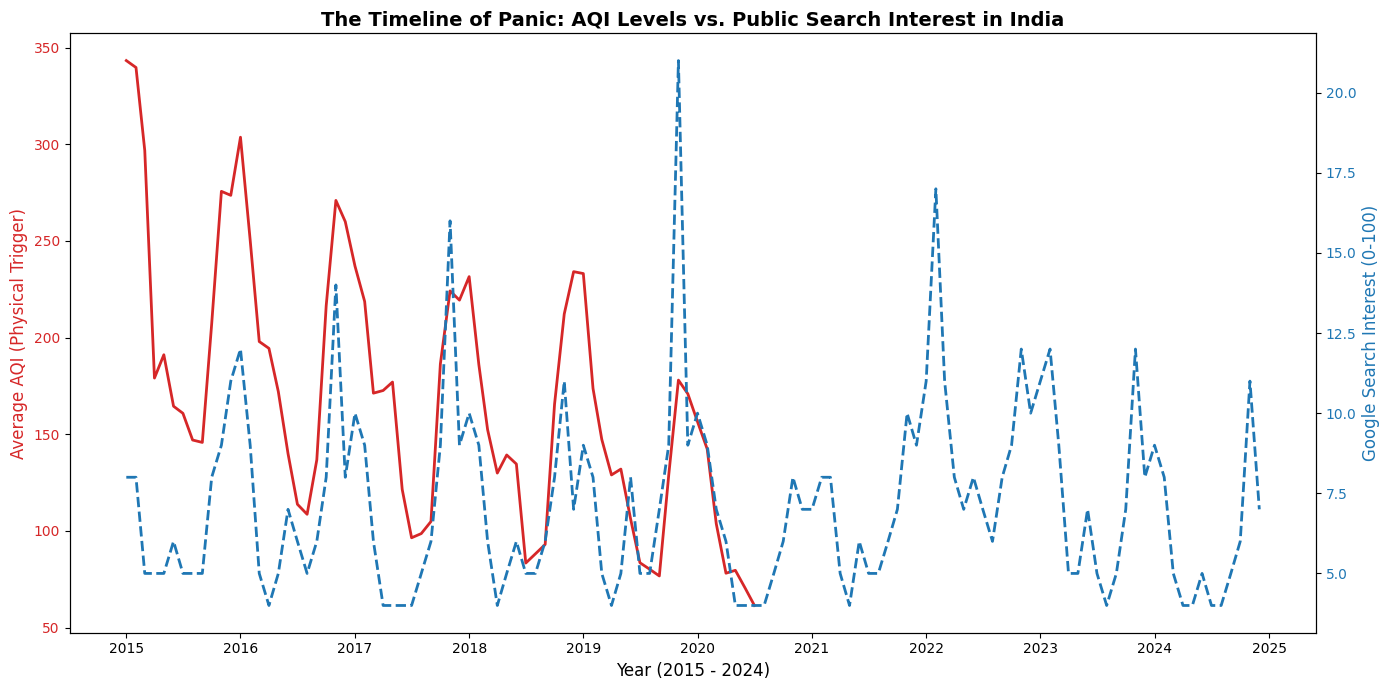

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq

# Connect to Google Trends (Setting language to English and Timezone to India)
pytrends = TrendReq(hl='en-IN', tz=330)

kw_list = ["air pollution", "climate change", "plastic waste", "air quality index", "global warming"]
print("Fetching data from Google... This might take a few seconds!")
pytrends.build_payload(kw_list, cat=0, timeframe='2015-01-01 2024-12-31', geo='IN', gprop='')
trends_data = pytrends.interest_over_time()

# Drop the 'isPartial' column that Google adds automatically
if 'isPartial' in trends_data.columns:
    trends_data = trends_data.drop(columns=['isPartial'])

# Prepare AQI data for matching
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_aqi = df.groupby('YearMonth')['AQI'].mean().reset_index()
monthly_aqi['YearMonth'] = monthly_aqi['YearMonth'].dt.to_timestamp()

# Create the Dual-Axis Chart for your research paper
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Physical AQI Data on the left axis
color = 'tab:red'
ax1.set_xlabel('Year (2015 - 2024)', fontsize=12)
ax1.set_ylabel('Average AQI (Physical Trigger)', color=color, fontsize=12)
ax1.plot(monthly_aqi['YearMonth'], monthly_aqi['AQI'], color=color, linewidth=2, label='Average AQI')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the Digital Google Trends Data
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Google Search Interest (0-100)', color=color2, fontsize=12)

# Plot the search interest for "air pollution"
ax2.plot(trends_data.index, trends_data['air pollution'], color=color2, linewidth=2, linestyle='--', label='Searches: "Air Pollution"')
ax2.tick_params(axis='y', labelcolor=color2)

# Add Titles and Legend
plt.title('The Timeline of Panic: AQI Levels vs. Public Search Interest in India', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.grid(False)
plt.show()

### Correlation between AQI and trends

In [102]:
aqi_for_math = monthly_aqi.copy()
aqi_for_math = aqi_for_math.set_index('YearMonth')

# We are putting the physical AQI next to the digital "air pollution" searches.
combined_data = pd.concat([aqi_for_math['AQI'], trends_data['air pollution']], axis=1)
combined_data = combined_data.dropna()

#Calculate the Pearson correlation score.
correlation_score = combined_data['AQI'].corr(combined_data['air pollution'])

print(f"The mathematical connection (correlation) between AQI and searching for 'air pollution' is: {correlation_score:.2f}")

The mathematical connection (correlation) between AQI and searching for 'air pollution' is: 0.49


# Region based trend

/tmp/ipython-input-3591261844.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states_pollution['air pollution'], y=top_states_pollution.index, palette='viridis')


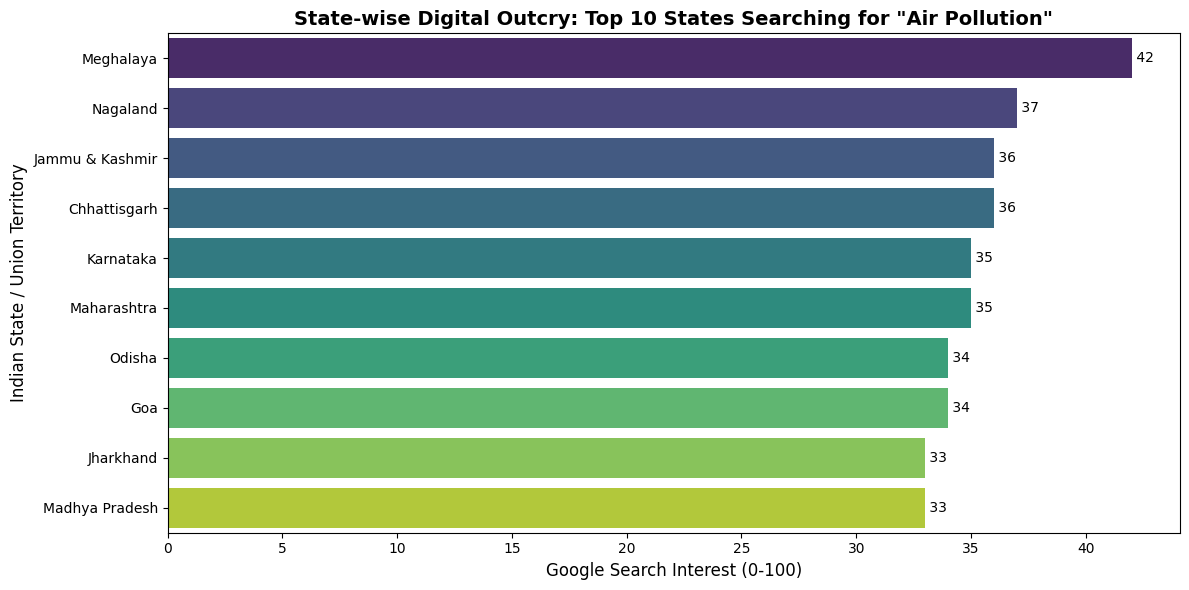

In [104]:
# We ask Google for data grouped by 'REGION', which in India means the States
state_trends = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False)
top_states_pollution = state_trends.sort_values(by='air pollution', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_states_pollution['air pollution'], y=top_states_pollution.index, palette='viridis')
plt.title('State-wise Digital Outcry: Top 10 States Searching for "Air Pollution"', fontsize=14, fontweight='bold')
plt.xlabel('Google Search Interest (0-100)', fontsize=12)
plt.ylabel('Indian State / Union Territory', fontsize=12)

# Display the exact scores on the bars
for index, value in enumerate(top_states_pollution['air pollution']):
    plt.text(value, index, f' {round(value, 1)}', va='center')

plt.tight_layout()
plt.show()

/tmp/ipython-input-1717029224.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states_pollution['plastic waste'], y=top_states_pollution.index, palette='viridis')


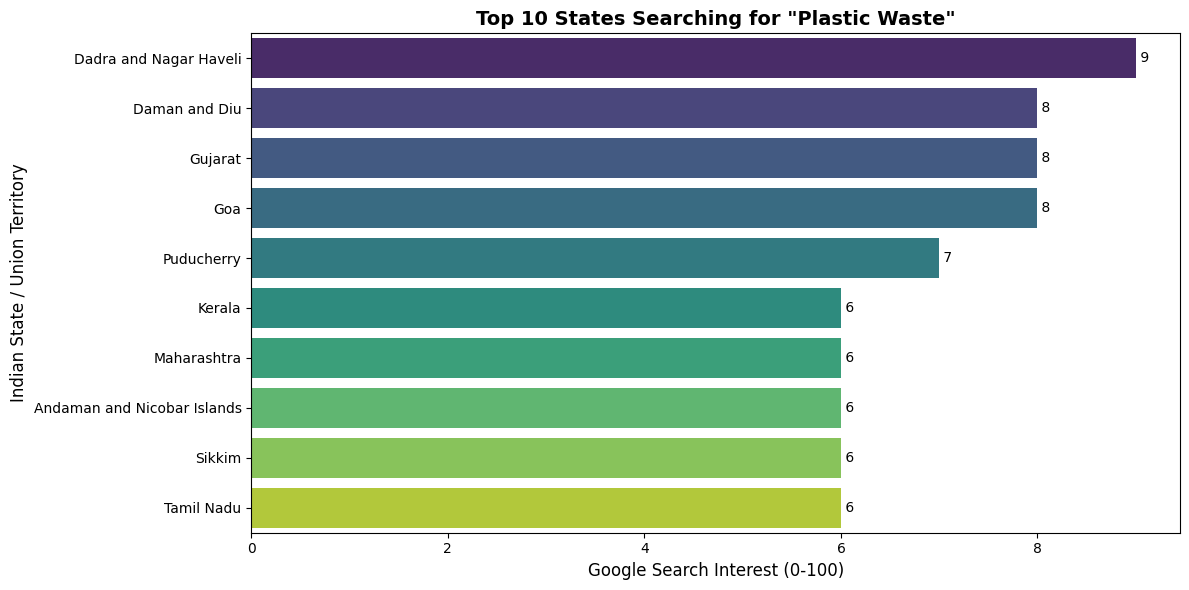

In [107]:
state_trends = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False)
top_states_pollution = state_trends.sort_values(by='plastic waste', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_states_pollution['plastic waste'], y=top_states_pollution.index, palette='viridis')
plt.title('Top 10 States Searching for "Plastic Waste"', fontsize=14, fontweight='bold')
plt.xlabel('Google Search Interest (0-100)', fontsize=12)
plt.ylabel('Indian State / Union Territory', fontsize=12)

# Display the exact scores on the bars
for index, value in enumerate(top_states_pollution['plastic waste']):
    plt.text(value, index, f' {round(value, 1)}', va='center')

plt.tight_layout()
plt.show()

# Government Expenditure on Pollution

**Data Source:** https://www.data.gov.in/resource/state-wise-expenditure-incurred-under-national-adaptation-fund-climate-change-2015-16-2019

In [108]:
import pandas as pd
df_exp = pd.read_csv('State-wise Expenditure.csv')
df_exp.head()

,S. No.,Category,States,Title of the Project,Total Cost of the Project,Amount Released
0,1,Approved and Sanctioned Projects in the F. Y. ...,Kerala,Promotion of integrated farming system of Kaip...,25.00,12.5
1,2,Approved and Sanctioned Projects in the F. Y. ...,Jammu & Kashmir,Climate Resilient Sustainable Agriculture in R...,22.51,11.25
2,3,Approved and Sanctioned Projects in the F. Y. ...,Mizoram,Sustainable Agriculture Development through Ex...,10.38,5.19
3,4,Approved and Sanctioned Projects in the F. Y. ...,Punjab,Towards Climate Resilient Livestock Production...,17.40,13.92
4,5,Approved and Sanctioned Projects in the F. Y. ...,Telangana,Resilient Agricultural Households through Adap...,24.00,6


In [109]:
#Remove the "Total" summary rows
df_exp = df_exp[~df_exp['States'].str.contains('Total', na=False)]
df_exp['States'] = df_exp['States'].str.split('(').str[0].str.strip()
df_exp['Amount Released'] = df_exp['Amount Released'].astype(str).str.extract(r'^([\d\.]+)').astype(float)

# Group the money by State
state_funding = df_exp.groupby('States')[['Total Cost of the Project', 'Amount Released']].sum().reset_index()
state_funding = state_funding.sort_values(by='Amount Released', ascending=False)

print("Data is perfectly clean! Here are the top funded states:\n")
print(state_funding[['States', 'Amount Released']].head(10))

Data is perfectly clean! Here are the top funded states:

                 States  Amount Released
0                                  60.33
25           Tamil Nadu            34.27
18  Multi State Project            34.13
23            Rajasthan            22.49
6               Gujarat            21.36
12               Kerala            17.50
16            Meghalaya            16.45
24               Sikkim            16.16
20               Odisha            16.00
8      Himachal Pradesh            15.00


/tmp/ipython-input-3802020117.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Funding_Per_Capita_Rupees', y='States', data=top_per_capita, palette='crest')


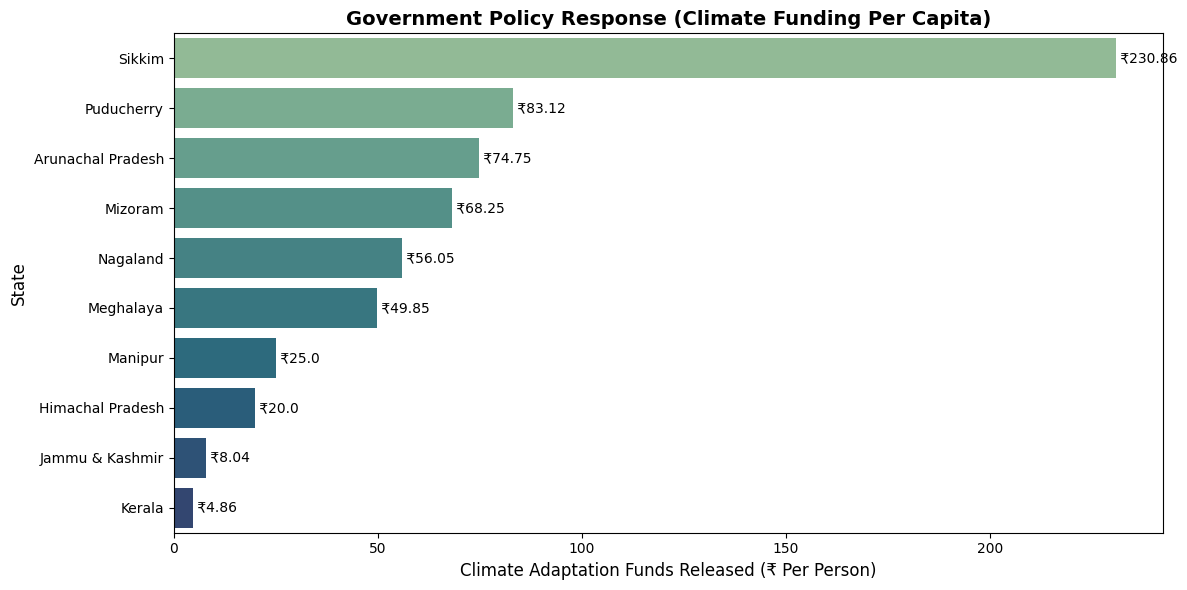

In [114]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


#Group the money by State
state_funding = df_exp.groupby('States')['Amount Released'].sum().reset_index()

#Population Dictionary (Numbers are rough estimates in Crores for math simplicity)
population_data = {
    'States': [
        # The 28 States
        'Uttar Pradesh', 'Maharashtra', 'Bihar', 'West Bengal', 'Madhya Pradesh',
        'Rajasthan', 'Tamil Nadu', 'Karnataka', 'Gujarat', 'Andhra Pradesh',
        'Odisha', 'Telangana', 'Kerala', 'Jharkhand', 'Assam', 'Punjab',
        'Chhattisgarh', 'Haryana', 'Uttarakhand', 'Himachal Pradesh', 'Tripura',
        'Meghalaya', 'Manipur', 'Nagaland', 'Goa', 'Arunachal Pradesh', 'Mizoram', 'Sikkim',
        # The 8 Union Territories
        'Delhi', 'Jammu & Kashmir', 'Puducherry', 'Chandigarh',
        'Dadra and Nagar Haveli and Daman and Diu', 'Andaman and Nicobar Islands',
        'Ladakh', 'Lakshadweep',
        # Adding our "Multi State" category from the dataset just in case
        'Multi State Project'
    ],
    'Population_Crores': [
        # States
        23.5, 12.6, 12.7, 10.0, 8.6,
        8.1, 7.7, 6.8, 7.1, 5.3,
        4.7, 3.8, 3.6, 4.0, 3.6, 3.0,
        3.0, 2.9, 1.1, 0.75, 0.41,
        0.33, 0.32, 0.22, 0.16, 0.16, 0.12, 0.07,
        # UTs
        3.1, 1.4, 0.16, 0.12,
        0.11, 0.04,
        0.03, 0.007,10.0
    ]
} # Added closing curly brace here
df_pop = pd.DataFrame(population_data)

#Merge the Funding data with the Population data
merged_funding = pd.merge(state_funding, df_pop, on='States', how='inner')
merged_funding['Funding_Per_Capita_Rupees'] = (merged_funding['Amount Released'] * 10000000) / (merged_funding['Population_Crores'] * 10000000)

# Sort the data to find the highest funded states per person
top_per_capita = merged_funding.sort_values(by='Funding_Per_Capita_Rupees', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Funding_Per_Capita_Rupees', y='States', data=top_per_capita, palette='crest')

plt.title('Government Policy Response (Climate Funding Per Capita)', fontsize=14, fontweight='bold')
plt.xlabel('Climate Adaptation Funds Released (₹ Per Person)', fontsize=12)
plt.ylabel('State', fontsize=12)

# Display the exact scores on the bars
for index, value in enumerate(top_per_capita['Funding_Per_Capita_Rupees']):
    plt.text(value, index, f' ₹{round(value, 2)}', va='center')

plt.tight_layout()
plt.show()

In [116]:
import pandas as pd


state_trends = state_trends.reset_index()
state_trends = state_trends.rename(columns={'geoName': 'States', 'air pollution': 'Search_Interest'})

final_comparison = pd.merge(merged_funding, state_trends, on='States', how='inner')

#Handle any missing data just in case
final_comparison['Funding_Per_Capita_Rupees'] = final_comparison['Funding_Per_Capita_Rupees'].fillna(0)

# Calculate the Mathematical Correlation
correlation_score = final_comparison['Funding_Per_Capita_Rupees'].corr(final_comparison['Search_Interest'])

print(f"The correlation between Digital Search Interest and Government Funding Per Capita is: {correlation_score:.2f}")

print("\nHere is the side-by-side comparison:")
print(final_comparison[['States', 'Search_Interest', 'Funding_Per_Capita_Rupees']].sort_values(by='Funding_Per_Capita_Rupees', ascending=False).head(10))

The correlation between Digital Search Interest and Government Funding Per Capita is: -0.14

Here is the side-by-side comparison:
               States  Search_Interest  Funding_Per_Capita_Rupees
22             Sikkim               27                 230.857143
19         Puducherry               30                  83.125000
1   Arunachal Pradesh               26                  74.750000
16            Mizoram               30                  68.250000
17           Nagaland               37                  56.045455
15          Meghalaya               42                  49.848485
14            Manipur               29                  25.000000
7    Himachal Pradesh               27                  20.000000
8     Jammu & Kashmir               36                   8.035714
11             Kerala               23                   4.861111
